In [12]:
class Student:

    def __init__ (self, name, age):
        self.name = name
        self.age = age
        # self.home = home


    def bark(self, to):
        self.to = to
        print(f"{self.name} says Woof to {self.to}")

    # def __str__(self):
    #     return f"Student(name={self.name}, age={self.age})"
    
student = Student("John", 20)
student.bark("everyone")
print(student)  # Output: Student(name=John, age=20)



John says Woof to everyone


In [49]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__() # Initialize nn.Module
        self.fc = nn.Linear(10, 5) # Linear layer with learnable weights
        
    def __call__(self, *input, **kwargs):
    # This is inside nn.Module class
        result = self.forward(*input, **kwargs)
        return result
    
    def forward(self, x):
        return self.fc(x)
        
    
    def __str__(self):
        return f"SimpleNet with {len(list(self.parameters()))} parameters"
    
    def named_parameters(self):
        return self.fc.named_parameters()
    
    def parameters(self):
        return self.fc.parameters()
    
    def to(self, device):
        self.fc.to(device)

    def cpu(self):
        self.fc.cpu()

    
    
net = SimpleNet()
x = torch.randn(1, 10)
out = net(x) # Calls forward

print(out.shape) # Output: torch.Size([1, 5])

torch.Size([1, 5])


In [44]:
# Let's see what nn.Linear(10, 5) creates
linear_layer = nn.Linear(10, 5)
print("=== Linear Layer Structure ===")
print(f"Weight shape: {linear_layer.weight.shape}")
print(f"Bias shape: {linear_layer.bias.shape}")
print(f"Weight requires_grad: {linear_layer.weight.requires_grad}")

# When you do self.fc = nn.Linear(10, 5), nn.Module automatically detects this
net = SimpleNet()
print("\n=== Auto-registered parameters ===")
for name, param in net.named_parameters():
    print(f"{name}: shape={param.shape}, requires_grad={param.requires_grad}")

=== Linear Layer Structure ===
Weight shape: torch.Size([5, 10])
Bias shape: torch.Size([5])
Weight requires_grad: True

=== Auto-registered parameters ===
weight: shape=torch.Size([5, 10]), requires_grad=True
bias: shape=torch.Size([5]), requires_grad=True


In [50]:
# When you do net(x), this is what actually happens:
x = torch.randn(1, 10)

# These are equivalent:
out1 = net(x)           # Calls net.__call__(x)
out2 = net.forward(x)   # Direct forward call

print(f"Are outputs equal? {torch.equal(out1, out2)}")


Are outputs equal? True


In [51]:
# Let's trace the forward pass step by step
net = SimpleNet()
x = torch.randn(1, 10)

print("=== Forward Pass Trace ===")
print(f"Input shape: {x.shape}")
print(f"Input values (first 5): {x[0, :5]}")

# Your forward method does: return self.fc(x)
# This calls nn.Linear.forward(x)
print("\n=== Inside nn.Linear ===")
weight = net.fc.weight  # Shape: [5, 10]
bias = net.fc.bias      # Shape: [5]

# Linear transformation: y = xW^T + b
# x: [1, 10], W^T: [10, 5], result: [1, 5]
manual_output = x @ weight.T + bias
network_output = net(x)

print(f"Manual calculation shape: {manual_output.shape}")
print(f"Network output shape: {network_output.shape}")
print(f"Results match: {torch.allclose(manual_output, network_output)}")

=== Forward Pass Trace ===
Input shape: torch.Size([1, 10])
Input values (first 5): tensor([-2.3046, -0.8263, -0.9221, -1.0448,  0.5828])

=== Inside nn.Linear ===
Manual calculation shape: torch.Size([1, 5])
Network output shape: torch.Size([1, 5])
Results match: True


In [53]:
# Let's add some debug prints to see the flow
class DebugNet(nn.Module):
    def __init__(self):
        super().__init__()
        print("2. nn.Module.__init__ completed")
        print("1. DebugNet.__init__ called")
        self.fc = nn.Linear(10, 5)
        print("3. Linear layer created and registered")
    
    def forward(self, x):
        print(f"4. forward() called with input shape: {x.shape}")
        result = self.fc(x)
        print(f"5. Linear layer processed, output shape: {result.shape}")
        return result

print("=== Creating network ===")
debug_net = DebugNet()

print("\n=== Running forward pass ===")
x = torch.randn(1, 10)
output = debug_net(x)  # This triggers the __call__ -> forward chain

print(f"\n=== Final result ===")
print(f"Output: {output}")

=== Creating network ===
2. nn.Module.__init__ completed
1. DebugNet.__init__ called
3. Linear layer created and registered

=== Running forward pass ===
4. forward() called with input shape: torch.Size([1, 10])
5. Linear layer processed, output shape: torch.Size([1, 5])

=== Final result ===
Output: tensor([[0.8299, 0.3776, 0.5377, 0.7951, 0.9097]], grad_fn=<AddmmBackward0>)


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

text = "hello, i am sam, i love vibe coding !!"
chars = sorted(list(set(text)))  # Unique characters
vocab_size = len(chars)
print(f"Unique characters: {chars}")

Unique characters: [' ', '!', ',', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 's', 'v']


Input shape: torch.Size([30, 8]), Target shape: torch.Size([30])


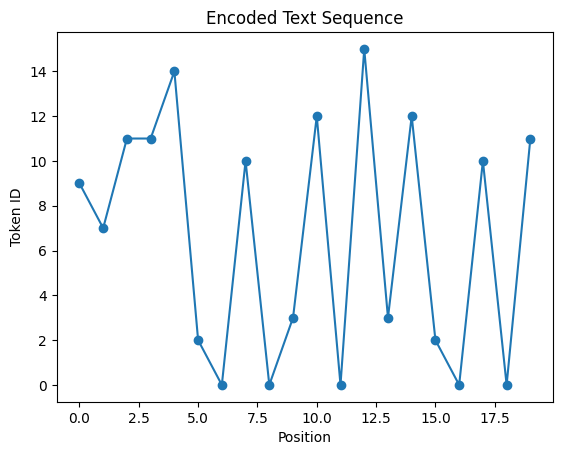

In [63]:
# Mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode data
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
block_size = 8  # Context length
X, y = [], []
for t in range(len(data) - block_size):
    X.append(data[t:t+block_size])
    y.append(data[t+block_size])
X = torch.stack(X)  # Shape: (num_examples, block_size)
y = torch.stack(y)  # Shape: (num_examples,)
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

# Visualize encoded data
plt.plot(data[:20].numpy(), marker='o')
plt.title("Encoded Text Sequence")
plt.xlabel("Position")
plt.ylabel("Token ID")
plt.show()

In [68]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 5)
        # Register buffer properly in __init__
        self.register_buffer('tril', torch.tril(torch.ones(4, 4)))

# Create new instance
net = SimpleNet()
print(net.tril)  # Now this will work

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


In [71]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()  # Essential initialization
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)
    
    def forward(self, x):  # Must implement forward()
        x = self.fc1(x)
        return self.fc2(x)

In [72]:
net = MyNet()

# Get all parameters (for optimizers)
params = list(net.parameters())
print(f"Total parameters: {sum(p.numel() for p in params)}")

# Get named parameters (for debugging)
for name, param in net.named_parameters():
    print(f"{name}: {param.shape}")

# Get specific layer parameters
fc1_params = list(net.fc1.parameters())
print(f"FC1 parameters: {len(fc1_params)}")

Total parameters: 61
fc1.weight: torch.Size([5, 10])
fc1.bias: torch.Size([5])
fc2.weight: torch.Size([1, 5])
fc2.bias: torch.Size([1])
FC1 parameters: 2


In [74]:
net = MyNet()

# Move to GPU/CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)

# Or specific methods
net = net.cuda()  # Move to GPU
# net = net.cpu()   # Move to CPU

# Check current device
print(f"Model device: {next(net.parameters()).device}")

Model device: cuda:0


In [78]:
net = MyNet()
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register forward hooks
net.fc1.register_forward_hook(get_activation('fc1'))
net.fc2.register_forward_hook(get_activation('fc2'))

# Run forward pass
x = torch.randn(1, 10)
output = net(x)

print(f"FC1 output shape: {activations['fc1']}")
print(f"FC2 output shape: {activations['fc2'].shape}")

FC1 output shape: tensor([[-0.0377,  0.4168,  0.4025,  0.1049, -0.0522]])
FC2 output shape: torch.Size([1, 1])


In [79]:
net = MyNet()

# Get all named modules
for name, module in net.named_modules():
    print(f"{name}: {module}")

# Get specific modules
for name, module in net.named_modules():
    if isinstance(module, nn.Linear):
        print(f"Linear layer: {name}, input_features: {module.in_features}")

: MyNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)
fc1: Linear(in_features=10, out_features=5, bias=True)
fc2: Linear(in_features=5, out_features=1, bias=True)
Linear layer: fc1, input_features: 10
Linear layer: fc2, input_features: 5


In [94]:
import torch
import torch.nn as nn

# Simple example: minimize (x - 3)²
x = torch.tensor([1.0], requires_grad=True)
target = 3.0

# Forward pass
prediction = x
loss = (prediction - target) ** 2
print(f"Initial: x={x.item():.2f}, loss={loss.item():.2f}")

# Backward pass - compute gradients
loss.backward()
print(f"Gradient dx: {x.grad}")
print(f"This tells us: move x in POSITIVE direction to reduce loss")

Initial: x=1.00, loss=4.00
Gradient dx: tensor([-4.])
This tells us: move x in POSITIVE direction to reduce loss


In [95]:
# Manual optimization - what happens inside optimizers
net = MyNet()
x_train = torch.randn(10, 10)
y_train = torch.randn(10, 1)

learning_rate = 0.01
criterion = nn.MSELoss()

print("=== MANUAL GRADIENT DESCENT ===")
for epoch in range(3):
    # Forward pass
    output = net(x_train)
    loss = criterion(output, y_train)
    
    # Backward pass
    loss.backward()
    
    # Manual parameter update
    with torch.no_grad(): # why we doing this? becuase we don't want to track these operations
        for param in net.parameters():
            param -= learning_rate * param.grad  # Update rule
            param.grad.zero_()  # Clear gradients manually
    
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

=== MANUAL GRADIENT DESCENT ===
Epoch 0: Loss = 1.3596
Epoch 1: Loss = 1.3266
Epoch 2: Loss = 1.2962


In [104]:
# Complete training example with detailed tracing
net = MyNet()
x_train = torch.randn(100, 10)
y_train = torch.randn(100, 1)

# Setup optimizer and loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

print("=== TRAINING LOOP TRACE ===")
for epoch in range(3):
    print(f"\n--- EPOCH {epoch} ---")
    
    # 1. Forward pass
    print("1. Forward pass...")
    output = net(x_train)
    loss = criterion(output, y_train)
    print(f"   Loss: {loss.item():.4f}")
    
    # 2. Zero gradients (CRUCIAL!)
    print("2. Zeroing gradients...")
    print(f"   Before zero_grad - fc1.weight.grad: {net.fc1.weight.grad}")
    optimizer.zero_grad()
    print(f"   After zero_grad - fc1.weight.grad: {net.fc1.weight.grad}")
    
    # 3. Backward pass
    print("3. Backward pass...")
    loss.backward()
    print(f"   After backward - fc1.weight.grad shape: {net.fc1.weight.grad.shape}")
    print(f"   Gradient sample: {net.fc1.weight.grad[0, :3]}")
    
    # 4. Parameter update
    print("4. Parameter update...")
    old_weight = net.fc1.weight.data[0, 0].clone()
    optimizer.step()
    new_weight = net.fc1.weight.data[0, 0]
    print(f"   Weight changed: {old_weight:.4f} → {new_weight:.4f}")
    print(f"   Change: {new_weight - old_weight:.6f}")

=== TRAINING LOOP TRACE ===

--- EPOCH 0 ---
1. Forward pass...
   Loss: 1.0797
2. Zeroing gradients...
   Before zero_grad - fc1.weight.grad: None
   After zero_grad - fc1.weight.grad: None
3. Backward pass...
   After backward - fc1.weight.grad shape: torch.Size([5, 10])
   Gradient sample: tensor([ 0.0081, -0.1068, -0.0788])
4. Parameter update...
   Weight changed: -0.2484 → -0.2584
   Change: -0.010000

--- EPOCH 1 ---
1. Forward pass...
   Loss: 1.0397
2. Zeroing gradients...
   Before zero_grad - fc1.weight.grad: tensor([[ 0.0081, -0.1068, -0.0788,  0.0512, -0.0172,  0.0076, -0.0561, -0.0782,
         -0.1522,  0.0731],
        [ 0.0093, -0.1223, -0.0902,  0.0586, -0.0197,  0.0087, -0.0642, -0.0895,
         -0.1742,  0.0837],
        [-0.0086,  0.1127,  0.0831, -0.0540,  0.0181, -0.0081,  0.0591,  0.0825,
          0.1605, -0.0771],
        [-0.0078,  0.1025,  0.0756, -0.0491,  0.0165, -0.0073,  0.0538,  0.0750,
          0.1460, -0.0701],
        [ 0.0040, -0.0530, -0.0391,  0

In [105]:
# Demonstration of gradient accumulation problem
net = MyNet()
x = torch.randn(5, 10)
y = torch.randn(5, 1)
criterion = nn.MSELoss()

print("=== WITHOUT zero_grad() - WRONG! ===")
for i in range(3):
    output = net(x)
    loss = criterion(output, y)
    loss.backward()  # No zero_grad()!
    
    # Gradients keep accumulating
    print(f"Step {i}: gradient magnitude = {net.fc1.weight.grad.abs().mean():.4f}")

print("\n=== WITH zero_grad() - CORRECT! ===")
for i in range(3):
    net.zero_grad()  # Clear gradients
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    
    print(f"Step {i}: gradient magnitude = {net.fc1.weight.grad.abs().mean():.4f}")

=== WITHOUT zero_grad() - WRONG! ===
Step 0: gradient magnitude = 0.0412
Step 1: gradient magnitude = 0.0823
Step 2: gradient magnitude = 0.1235

=== WITH zero_grad() - CORRECT! ===
Step 0: gradient magnitude = 0.0412
Step 1: gradient magnitude = 0.0412
Step 2: gradient magnitude = 0.0412


In [106]:
# Let's see what different optimizers do
net1 = MyNet()
net2 = MyNet()

# Copy same initial weights
net2.load_state_dict(net1.state_dict())

# Different optimizers
sgd_optimizer = torch.optim.SGD(net1.parameters(), lr=0.01)
adam_optimizer = torch.optim.Adam(net2.parameters(), lr=0.01)

x = torch.randn(10, 10)
y = torch.randn(10, 1)
criterion = nn.MSELoss()

print("=== COMPARING OPTIMIZERS ===")
for epoch in range(3):
    # SGD update
    sgd_optimizer.zero_grad()
    loss1 = criterion(net1(x), y)
    loss1.backward()
    sgd_optimizer.step()
    
    # Adam update  
    adam_optimizer.zero_grad()
    loss2 = criterion(net2(x), y)
    loss2.backward()
    adam_optimizer.step()
    
    print(f"Epoch {epoch}: SGD loss={loss1.item():.4f}, Adam loss={loss2.item():.4f}")

=== COMPARING OPTIMIZERS ===
Epoch 0: SGD loss=0.7923, Adam loss=0.7923
Epoch 1: SGD loss=0.7365, Adam loss=0.6850
Epoch 2: SGD loss=0.6865, Adam loss=0.5892


=== REAL TRAINING EXAMPLE ===
Epoch 0: Train Loss=15.3780, Test Loss=14.2444
Epoch 20: Train Loss=10.9764, Test Loss=9.8511
Epoch 40: Train Loss=4.3871, Test Loss=3.7784
Epoch 60: Train Loss=0.6931, Test Loss=0.7205
Epoch 80: Train Loss=0.0595, Test Loss=0.0564


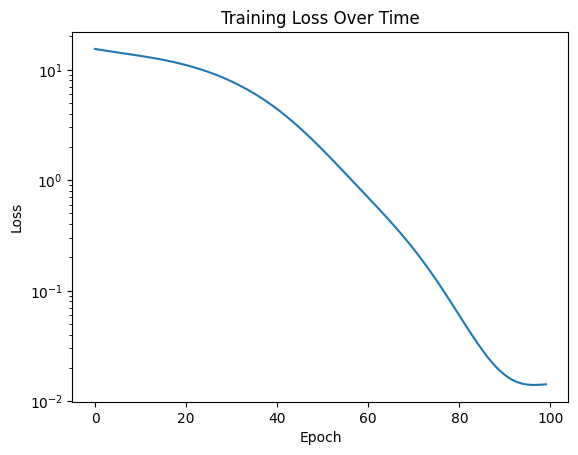

Final train loss: 0.0142


In [115]:
# Real training example with synthetic data
import matplotlib.pyplot as plt

# Create synthetic dataset
torch.manual_seed(42)
n_samples = 1000
X = torch.randn(n_samples, 10)
# True relationship: y = sum of first 3 features + noise
true_weights = torch.zeros(10)
true_weights[:3] = torch.tensor([2.0, -1.5, 3.0])
y = X @ true_weights + 0.1 * torch.randn(n_samples)
y = y.unsqueeze(1)

# Split data
train_size = 800
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Model and training setup
net = MyNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop with tracking
losses = []
print("=== REAL TRAINING EXAMPLE ===")

for epoch in range(100):
    # Training
    net.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = net(X_train)
    loss = criterion(predictions, y_train)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 20 == 0:
        # Test evaluation
        net.eval()
        with torch.no_grad():
            test_pred = net(X_test)
            test_loss = criterion(test_pred, y_test)
        
        print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")

# Plot training curve
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

print(f"Final train loss: {losses[-1]:.4f}")

In [118]:
# Prevents PyTorch from tracking operations for gradients
x = torch.randn(5, requires_grad=True)

# Normal operation - gradients tracked
y1 = x * 2
print(f"Normal: y1.requires_grad = {y1.requires_grad}")  # True

# With no_grad - gradients NOT tracked
with torch.no_grad():
    y2 = x * 2
    print(f"No grad: y2.requires_grad = {y2.requires_grad}")  # False

Normal: y1.requires_grad = True
No grad: y2.requires_grad = False


In [119]:
# Resets accumulated gradients to zero
net = MyNet()
x = torch.randn(10, 10)
y = torch.randn(10, 1)
criterion = nn.MSELoss()

# First forward/backward pass
loss = criterion(net(x), y)
loss.backward()
print(f"After 1st backward: grad = {net.fc1.weight.grad[0, 0]:.4f}")

# Second backward without zero_grad - ACCUMULATES!
loss = criterion(net(x), y)
loss.backward()
print(f"After 2nd backward: grad = {net.fc1.weight.grad[0, 0]:.4f}")  # Doubled!

# Now clear gradients
optimizer = torch.optim.Adam(net.parameters())
optimizer.zero_grad()
print(f"After zero_grad: grad = {net.fc1.weight.grad}")  # None or zeros

After 1st backward: grad = -0.0600
After 2nd backward: grad = -0.1201
After zero_grad: grad = None


In [120]:
net = MyNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
x_train = torch.randn(100, 10)
y_train = torch.randn(100, 1)
x_test = torch.randn(50, 10)
y_test = torch.randn(50, 1)

print("=== TRAINING vs EVALUATION ===")

# TRAINING PHASE - Need gradients
net.train()
optimizer.zero_grad()  # Clear old gradients
predictions = net(x_train)
loss = criterion(predictions, y_train)
loss.backward()  # Compute gradients
optimizer.step()  # Update weights
print(f"Training loss: {loss.item():.4f}")

# EVALUATION PHASE - Don't need gradients  
net.eval()
with torch.no_grad():  # Disable gradient computation
    test_predictions = net(x_test)
    test_loss = criterion(test_predictions, y_test)
print(f"Test loss: {test_loss.item():.4f}")

=== TRAINING vs EVALUATION ===
Training loss: 1.4259
Test loss: 1.2981
